In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import json
from pathlib import Path 

sys.path.append(str(Path.cwd().parent / 'scripts'))
from _aggregation_helpers import flexible_aggregate

In [133]:
dates = pd.date_range('2022-07', '2024-07', freq='m').strftime('%Y-%m')

path = Path.cwd().parent / 'results'

def agg_month(date):
    """month to aggregate"""

    if isinstance(date, pd.Timestamp):
        date = date.strftime('%Y-%m')

    ts = str(int(pd.Timestamp(date).timestamp()))

    hierarchy = ['daily', 'half-hourly', 'periods']
    gathered_files = None

    def should_be_added(fn, nonadds):

        if nonadds is not None:
            condition2 = lambda fn: fn.startswith(nonadds)
        else:
            condition2 = lambda _: False

        return (fn.startswith(date) + condition2(fn)) == 1

    for level in hierarchy:

        if gathered_files is not None:
            cleaned = tuple(map(lambda entry: entry.split('.')[0], gathered_files))
        else:
            cleaned = None

        level_files = tuple([fn for fn in os.listdir(path / level) if should_be_added(fn, cleaned)])

        if gathered_files is None:
            gathered_files = level_files
        else:     
            gathered_files += level_files


    total_periods = 48 * len(
        pd.date_range(
            pd.Timestamp(date),
            pd.Timestamp(date) + pd.offsets.MonthEnd(1),
            freq='d'
        )
    )

    num_period_mapper = {
        12: total_periods,
        15: 48,
        17: 1,
        18: 1,
    }
    num_path_mapper = {
        12: 'daily',
        15: 'half-hourly',
        17: 'periods',
        18: 'periods',
    }

    covered_periods = pd.Series(gathered_files).map(len).map(num_period_mapper).sum()
    covered_share = covered_periods / total_periods
    
    def get_json(fn):
        with open(fn, 'r') as f:
            return json.load(f)

    results = {}
    
    for d, fn in zip(pd.Series(gathered_files).map(len).map(num_path_mapper), gathered_files):
        results.update(get_json(path / d / fn))

    return {ts: flexible_aggregate(results)}, covered_share
    # return covered_share

monthly_results = {}
shares = pd.Series(index=dates)

from tqdm import tqdm

for date in tqdm(dates):
    result, share = agg_month(date)

    shares[date] = share
    monthly_results.update(result)

# total = agg_month(dates[1])

100%|██████████| 24/24 [10:47<00:00, 26.99s/it]


<AxesSubplot:>

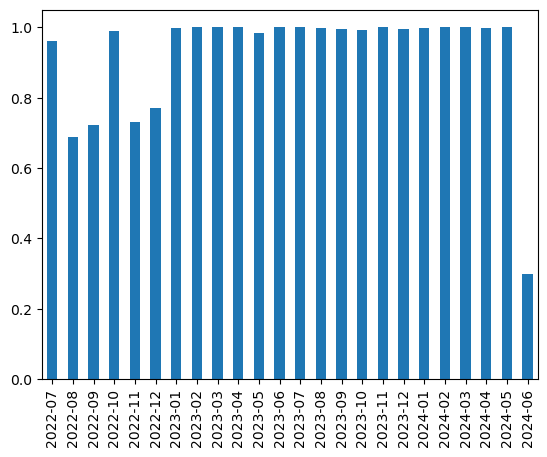

In [131]:
shares.plot.bar()

In [135]:
from pprint import pprint

total = flexible_aggregate(monthly_results)

In [139]:

for l in list(total):
    ts = total[l]

    i = ts['globals']['variables']

    ts = sum([item for key, item in i.items() if 'savings' in key])

    print(l, ts*1e-9)

# pprint(total['nodal']['globals'])
# pprint(total['eso']['globals'])
# pprint(total['national']['globals'])

national 0.0
nodal 4.475878320267355
eso 2.734613306909588


In [140]:
list(total['nodal']['globals']['variables'])

['wholesale_cost',
 'balancing_cost',
 'congestion_rent',
 'cfd_cost',
 'wholesale_cost_savings',
 'balancing_cost_savings',
 'congestion_rent_savings',
 'cfd_cost_savings']

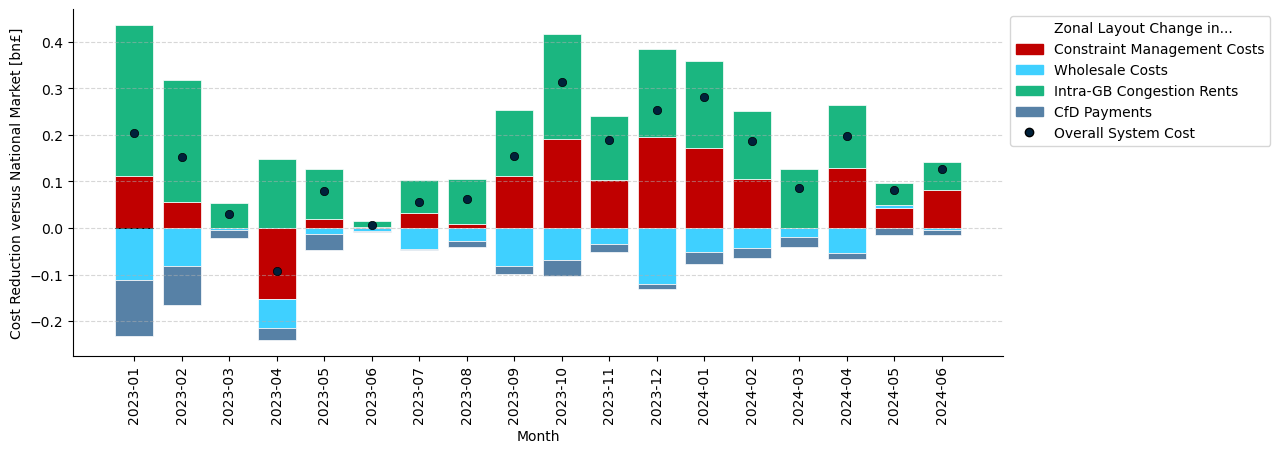

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4.5))

colors = {
    'balancing_cost_savings': '#c00000',
    'wholesale_cost_savings': '#3fd0ff',
    'congestion_rent_savings': '#1bb680',
    'cfd_cost_savings': '#5781a6',
    'total': '#00213b',
}

nice_names = {
    'balancing_cost_savings': 'Constraint Management Costs',
    'wholesale_cost_savings': 'Wholesale Costs',
    'congestion_rent_savings': 'Intra-GB Congestion Rents',
    'cfd_cost_savings': 'CfD Payments',
}

quants = list(nice_names)

l = 'eso'

ttt = 0
plotstart = pd.Timestamp('2023-01')

for i, data in monthly_results.items():

    if pd.Timestamp.fromtimestamp(int(i)) < plotstart:
        continue

    data = (
        pd.Series(
            data[l]['globals']['variables']
        )
        .loc[quants]
        .mul(1e-9)
        .rename(
            (dt := pd.Timestamp.fromtimestamp(int(i)).strftime('%Y-%m'))
        )
    )

    ttt += data.sum()

    neg = data[data < 0]
    pos = data[data > 0]

    negcum = neg.cumsum()
    poscum = pos.cumsum()

    total_b = data.sum()

    bar_kwargs = dict(    
        edgecolor='white',
        linewidth=0.5,
    )

    for q, val in neg.items():
        ax.bar(dt, val, color=colors[q], bottom=negcum[q] - val, **bar_kwargs)
    
    for q, val in pos.items():
        ax.bar(dt, val, color=colors[q], bottom=poscum[q] - val, **bar_kwargs)

    ax.scatter([dt], [total_b], color=colors['total'], zorder=10, edgecolor='black', linewidth=0.5)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Cost Reduction versus National Market [bn£]')

for q, col in nice_names.items():
    ax.bar(0, 0, color=colors[q], label=nice_names[q], edgecolor='black', linewidth=0.5)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

handles, labels = [], []

handles.append(Line2D([0], [0], color='w', lw=0, label=''))

nice_lname = {
    'nodal': 'Nodal Layout',
    'eso': 'Zonal Layout',
}
labels = [f'{nice_lname[l]} Change in...']

for n, nn in nice_names.items():
    handles.append(Patch(color=colors[n]))
    labels.append(nn)

handles.append(Line2D([0], [0], color='w', marker='o', label='', markerfacecolor=colors['total'], markeredgecolor='black'))
labels.append('Overall System Cost')

ax.legend(
    handles, labels,
    # loc='lower right',
    bbox_to_anchor=(1, 1),
)

ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('Month')

plt.savefig(f'monthly_totals_{l}.pdf')
plt.show()

In [64]:
dd = pd.date_range(pd.Timestamp(dates[0]), pd.Timestamp(dates[0]) + pd.offsets.MonthEnd(1))
len(dd)

31

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12',
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-20',
               '2024-01-21', '2024-01-22', '2024-01-23', '2024-01-24',
               '2024-01-25', '2024-01-26', '2024-01-27', '2024-01-28',
               '2024-01-29', '2024-01-30', '2024-01-31'],
              dtype='datetime64[ns]', freq='D')

In [13]:
pd.Timestamp.fromtimestamp(pd.Timestamp(dates[0]).timestamp())

Timestamp('2024-01-01 01:00:00')

In [20]:
# pd.Series(['aa', 'bb', 'cc']).str.startswith('aaah')
'aaahh'.startswith(tuple(pd.Series(['auu', 'bb', 'cc'])))

False

In [31]:
a = (1,2,3) + (4,)
a

(1, 2, 3, 4)

(1, 2, 3, 4)